# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$ \nabla_w ( \ln(1+\exp(-y\langle w, x \rangle)) =- \frac{\exp(-y\langle w, x \rangle)}{1+\exp(-y\langle w, x \rangle))} y x = \left \{ \sigma(z) = \frac {1}{1 + \exp(-z)}\right \}= - \sigma(-y\langle w, x \rangle) y x  $$ 

$$ \nabla_w ( \gamma  \|w\|_1) = \gamma \nabla_w ( \|w\|_1) = \gamma sign(w) $$ 

$$ \nabla_w (\beta \|w\|_2^2) = \beta \nabla_w ( \|w\|_2^2) = 2\beta w  $$ 

$$\nabla_w L(w, w_0) = \nabla_w ( \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2) = - \frac{1}{N} \sum_{i=1}^N (\sigma(-y_i(w^\top x_i + w_0)) y_i x_i ) + \gamma sign(w) + 2\beta w $$ 
 $$\nabla _{w_0} L(w, w_0) = - \frac{1}{N} \sum_{i=1}^N \sigma(-y_i (w^\top x_i + w_0)) y_i $$

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param w: np.ndarray of shape (n_features,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """
    
    return np.mean(np.log(1 + np.exp(-y*(np.dot(X,w)+w0)))) + gamma * np.linalg.norm(w, 1) + beta * (np.linalg.norm(w))**2

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    params:
    z – A scalar or numpy array of any size.
    '''
    return  1/(1+np.exp(-z))

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.):# -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_features,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''
    return [-np.mean(X.T*sigmoid(-y*(np.dot(X,w)+w0))*y, 1) + gamma * np.sign(w) + 2 * beta * w, np.mean(-sigmoid(-y*(np.dot(X,w)+w0))*y)]

#### Check yourself

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)

assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [7]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1., gamma=1., lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=2):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.loss_list = []
        self.threshold = 0.5
  
        # you may additional properties if you wish
        
        
    def fit(self, X, y):
        
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        np.random.seed(self.random_state)
        self.w, self.w0 = np.random.normal(size=X.shape[1]), np.random.normal()
        movement = 1
        i = 0
        while movement > self.tolerance and i < self.max_iter:
            dw, dw0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -=  self.learning_rate * dw
            self.w0 -=  self.learning_rate * dw0
            movement = np.linalg.norm(self.learning_rate * dw)
            self.loss_list.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))
            i += 1
        fpr, tpr, thresholds = roc_curve(y, self.predict_proba(X))
        self.threshold = thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]
        return self
     
    
    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        return np.where(self.predict_proba(X) < self.threshold, 0, 1)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        return sigmoid(np.dot(X, self.w) + self.w0)

In [8]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [9]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

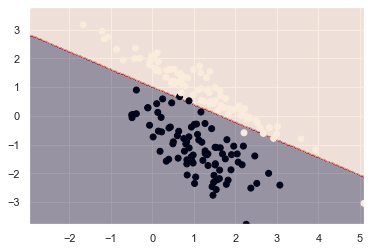

In [10]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0.5, 1.0, 'Loss(steps)')

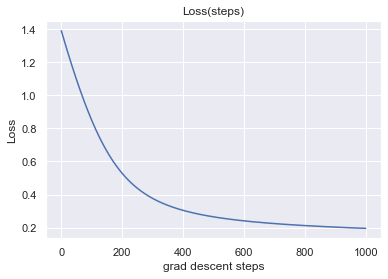

In [11]:
plt.plot(model.loss_list)
plt.ylabel('Loss')
plt.xlabel('grad descent steps')
plt.title('Loss(steps)')

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [53]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=13)
c = np.linspace(0.1, 0.01, 10)
accuracy = [[],[],[]]
roc_auc = [[],[],[]]
f1 = [[],[],[]]
score = [accuracy, roc_auc, f1]
kernel = ['linear', 'rbf', 'poly']
sc = ['accuracy', 'roc_auc', 'f1']

In [14]:
for i in range(3):
    for c_reg in c:
        model = SVC(kernel=kernel[i], C=c_reg).fit(X_train, y_train)
        pred = model.predict(X_test)
        score[0][i].append(accuracy_score(y_test, pred))
        score[1][i].append(roc_auc_score(y_test, pred))
        score[2][i].append(f1_score(y_test, pred))

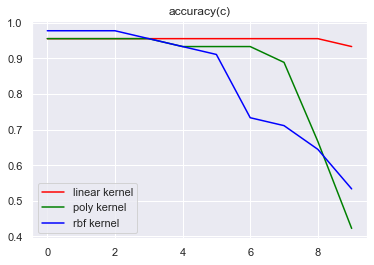

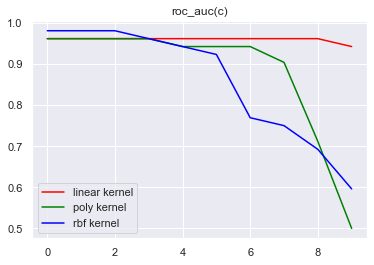

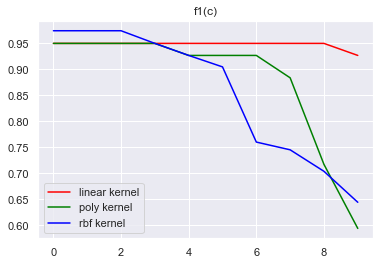

In [15]:
for i in range(3):
    plt.plot(score[i][0], label='linear kernel', color = 'red')
    plt.plot(score[i][1], label='poly kernel', color = 'green')
    plt.plot(score[i][2], label='rbf kernel', color = 'blue')
    plt.title(sc[i]+'(c)')
    plt.legend()
    plt.show()

As we see from the graphs, SVM with poly and rbf kernels are prone to overfitting and their score decreases faster with increasing of regularization coefficient. 

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [28]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix

vectorizer_1 = TfidfVectorizer()
vectorizer = CountVectorizer()
mystem = Mystem()
stopwords = nltk.corpus.stopwords.words('russian')

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation+'—'+'–'+'1234567890'])
    return punctuationfree
def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output
def lemmatizer(text):
    lemm_text = [mystem.lemmatize(word)[0] for word in text]
    return lemm_text

In [17]:
chehov_splited, tolstoy_splited, brusov_splited, herzen_splited, gorky_splited, turgenev_splited = [],[],[],[],[],[]
dataset = []

with open('chehov.txt', 'r') as iofile:
    chehov = iofile.readlines()
for abz in chehov:
    chehov_splited.append(re.split(r'(?<=[.!?…]) ', abz))
for sen in sum(chehov_splited,[]):
    if(len(sen) > 15):
        dataset.append([re.sub('\n', '', sen), 'Чехов'])

with open('tolstoy.txt', 'r') as iofile:
    tolstoy = iofile.readlines()
for abz in tolstoy:
    tolstoy_splited.append(re.split(r'(?<=[.!?…]) ', abz))
for sen in sum(tolstoy_splited,[]):
    if(len(sen) > 15):
        dataset.append([re.sub('\n', '', sen), 'Толстой'])
        
with open('brusov.txt', 'r') as iofile:
    brusov = iofile.readlines()
for abz in brusov:
    brusov_splited.append(re.split(r'(?<=[.!?…]) ', abz))
for sen in sum(brusov_splited,[]):
    if(len(sen) > 15):
        dataset.append([re.sub('\n', '', sen), 'Брюсов'])
        
with open('herzen.txt', 'r') as iofile:
    herzen = iofile.readlines()
for abz in herzen:
    herzen_splited.append(re.split(r'(?<=[.!?…]) ', abz))
for sen in sum(herzen_splited,[]):
    if(len(sen) > 15):
        dataset.append([re.sub('\n', '', sen), 'Герцен'])

with open('gorky.txt', 'r') as iofile:
    gorky = iofile.readlines()
for abz in gorky:
    gorky_splited.append(re.split(r'(?<=[.!?…]) ', abz))
for sen in sum(gorky_splited,[]):
    if(len(sen) > 15):
        dataset.append([re.sub('\n', '', sen), 'Горький'])

with open('turgenev.txt', 'r') as iofile:
    turgenev = iofile.readlines()
for abz in turgenev:
    turgenev_splited.append(re.split(r'(?<=[.!?…]) ', abz))
for sen in sum(turgenev_splited,[]):
    if(len(sen) > 15):
        dataset.append([re.sub('\n', '', sen), 'Тургенев'])
        
dataset = pd.DataFrame(dataset, columns=['sentence', 'author'])
dataset

,sentence,author
0,"На палубе парохода, шедшего из Одессы в Севаст...",Чехов
1,"— Обратите внимание на этих немцев, что сидят ...",Чехов
2,"Когда сойдутся немцы или англичане, то говорят...",Чехов
3,Но главное — о женщинах.,Чехов
4,Лицо этого господина было уже знакомо мне.,Чехов
...,...,...
10342,"Трудно сказать, что происходит в этой душе: но...",Тургенев
10343,"Муж Ирины быстро подвигается на том пути, к...",Тургенев
10344,Тучный генерал обскакивает его; снисходительны...,Тургенев
10345,"И в том же городе, где проживает Ирина, прожив...",Тургенев


In [18]:
k = 30
dataset = pd.concat([
    (dataset.loc[dataset['author'] == 'Чехов']).sample(3*k),
    (dataset.loc[dataset['author'] == 'Герцен']).sample(7*k),
    (dataset.loc[dataset['author'] == 'Горький']).sample(15*k),
    (dataset.loc[dataset['author'] == 'Брюсов']).sample(20*k),
    (dataset.loc[dataset['author'] == 'Толстой']).sample(30*k),
    (dataset.loc[dataset['author'] == 'Тургенев']).sample(40*k)
])
dataset['clean']= dataset['sentence'].apply(lambda x:lemmatizer(remove_stopwords(remove_punctuation(x).lower().split())))
dataset

,sentence,author,clean
264,"Дома в деревне мне бывало стыдно от мужиков, к...",Чехов,"[дома, деревня, бывало, стыдно, мужик, будни, ..."
410,"Но она была дьявольски хитра и остроумна, и в ...",Чехов,"[дьявольски, хитрый, остроумный, общество, уме..."
358,На первых порах он казался оригинальным и возб...,Чехов,"[первый, пора, казаться, оригинальный, возбужд..."
129,"Я уважаю женщин не меньше вашего, но думаю, чт...",Чехов,"[уважать, женщина, мало, ваш, думать, известны..."
418,"Я не люблю беременности и родов, но теперь уже...",Чехов,"[любить, беременность, род, мечтать, ребенок, ..."
...,...,...,...
8316,не в такой степени!,Тургенев,[степень]
9420,"– Успеем, тетя.",Тургенев,"[успевать, тетя]"
7247,"Все наши расколы, наши Онуфриевщины да Акулино...",Тургенев,"[наш, раскол, наш, онуфриевщина, акулиновщина,..."
9753,Татьяна приблизилась к Литвинову.,Тургенев,"[татьяна, приближаться, литвинов]"


In [19]:
data = [" ".join(list(dataset['clean'])[i]) for i in range(dataset.shape[0])]
bag = vectorizer.fit_transform(data)
tf_idf = vectorizer_1.fit_transform(data)
dataset['bag'] = list(bag.toarray())
dataset['tf_idf'] = list(tf_idf.toarray())
dataset

,sentence,author,clean,bag,tf_idf
264,"Дома в деревне мне бывало стыдно от мужиков, к...",Чехов,"[дома, деревня, бывало, стыдно, мужик, будни, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
410,"Но она была дьявольски хитра и остроумна, и в ...",Чехов,"[дьявольски, хитрый, остроумный, общество, уме...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
358,На первых порах он казался оригинальным и возб...,Чехов,"[первый, пора, казаться, оригинальный, возбужд...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
129,"Я уважаю женщин не меньше вашего, но думаю, чт...",Чехов,"[уважать, женщина, мало, ваш, думать, известны...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
418,"Я не люблю беременности и родов, но теперь уже...",Чехов,"[любить, беременность, род, мечтать, ребенок, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
8316,не в такой степени!,Тургенев,[степень],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9420,"– Успеем, тетя.",Тургенев,"[успевать, тетя]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7247,"Все наши расколы, наши Онуфриевщины да Акулино...",Тургенев,"[наш, раскол, наш, онуфриевщина, акулиновщина,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9753,Татьяна приблизилась к Литвинову.,Тургенев,"[татьяна, приближаться, литвинов]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
#are they equal?
0 == np.linalg.norm(np.array(bag.toarray())[0] - np.array(tf_idf.toarray())[0])

False

In [21]:
#are their non-zero elements the same?
sum(np.where(np.array(tf_idf.toarray())[0] == 0, 0, 1) == np.array(bag.toarray())[0]) - np.array(tf_idf.toarray())[0].shape[0] < 1

True

As we see, Bag Vectorizer give number of frequency with respect to index of vocabulary where as TF-IDF consider overall sentencies of weight of words. So elements of bag vectors are integer, while elements of tf-idf vectors are float.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [22]:
dataset = pd.concat([
    dataset.loc[dataset['author'] == 'Тургенев'],
    dataset.loc[dataset['author'] == 'Толстой']
    ])

In [23]:
X = pd.DataFrame(list(dataset['bag'])).to_numpy()
y = np.where(np.array(dataset['author']) == 'Тургенев', 0, 1)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=13)

In [27]:
model = SVC().fit(X_train, y_train)
scores = cross_validate(model, X, y, cv=3, scoring=('accuracy', 'roc_auc', 'f1'), return_train_score=True)
scores

{'fit_time': array([19.13971615, 15.19650722, 23.92545915]),
 'score_time': array([19.47605395, 14.80963302, 20.09104395]),
 'test_accuracy': array([0.73142857, 0.74714286, 0.75285714]),
 'train_accuracy': array([0.91071429, 0.90857143, 0.90928571]),
 'test_roc_auc': array([0.79755417, 0.82035417, 0.80393333]),
 'train_roc_auc': array([0.99341146, 0.99449688, 0.99443854]),
 'test_f1': array([0.5982906 , 0.62420382, 0.64182195]),
 'train_f1': array([0.88415199, 0.88170055, 0.88273315])}

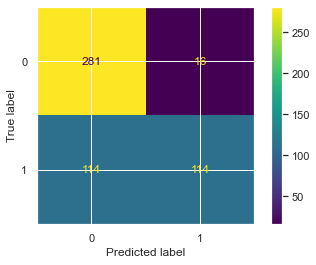

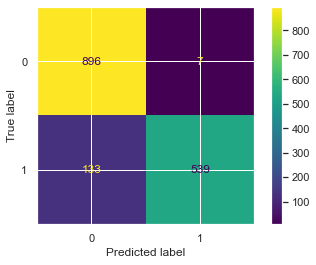

In [29]:
plot_confusion_matrix(model, X_test, y_test, labels=['Тургенев','Толстой'])  
plt.show()
plot_confusion_matrix(model, X_train, y_train, labels= ['Тургенев','Толстой'])  
plt.show()

In [50]:
'''
model = Logit(0,0)
scores = cross_validate(model, X, y, cv=5, scoring=('accuracy'), return_train_score=True)
scores
plot_confusion_matrix(model, X_test, y_test, labels=['Тургенев','Толстой'])  
plt.show()
plot_confusion_matrix(model, X_train, y_train, labels= ['Тургенев','Толстой'])  
plt.show()
'''

"\nmodel = Logit(0,0)\nscores = cross_validate(model, X, y, cv=5, scoring=('accuracy'), return_train_score=True)\nscores\nplot_confusion_matrix(model, X_test, y_test, labels=['Тургенев','Толстой'])  \nplt.show()\nplot_confusion_matrix(model, X_train, y_train, labels= ['Тургенев','Толстой'])  \nplt.show()\n"

Turgenev are more recognizable by model then Tolstoy. If model predict label 'Tolstoy' it is more likely 'Tolstoy', but if label 'Turgenev' was predicted, true label can also be 'Tolstoy'.

In [36]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 1, 10]}
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(X, y)
clf.cv_results_

{'mean_fit_time': array([16.09353991, 19.54608192, 20.92599072, 18.07838016, 19.15996218,
        20.83356338, 19.58633804, 20.47455006, 22.41658816]),
 'std_fit_time': array([0.17332192, 0.05379098, 0.14580154, 1.60126477, 0.12334822,
        0.13865584, 4.01711166, 0.17164811, 1.17946597]),
 'mean_score_time': array([3.90179887, 4.81838799, 5.16137471, 3.19061823, 4.72682915,
        5.13177052, 2.81106553, 4.49167924, 5.85693588]),
 'std_score_time': array([0.0165479 , 0.02078577, 0.01195272, 0.01199322, 0.02647296,
        0.0075921 , 0.0232378 , 0.01899299, 0.70689468]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'poly', 'linear', 'rbf', 'poly',
                    'linear', 'rbf', 'poly'],
              mask=[False, False, False, False, False, False,

Best score – C=0.1 and linear kernel.

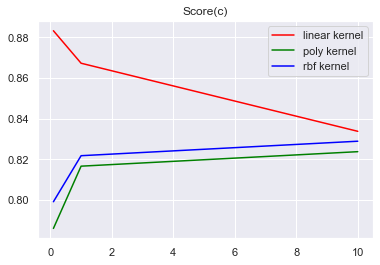

In [49]:
plt.plot([0.1,1,10],[clf.cv_results_['mean_test_score'][i] for i in [0,3,6]], label='linear kernel', color = 'red')
plt.plot([0.1,1,10],[clf.cv_results_['mean_test_score'][i] for i in [2,5,8]], label='poly kernel', color = 'green')
plt.plot([0.1,1,10],[clf.cv_results_['mean_test_score'][i] for i in [1,4,7]], label='rbf kernel', color = 'blue')
plt.title('Score(c)')
plt.legend()
plt.show()

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [56]:
def plot_roc(labels, predictions, positive_label, thresholds_every=10, title=''):
    # fp: false positive rates. tp: true positive rates
    fp, tp, thresholds = roc_curve(labels, predictions, pos_label=positive_label)
    roc_auc = auc(fp, tp)

    plt.figure(figsize=(16, 16))
    plt.plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=2, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

    # plot some thresholds
    thresholdsLength = len(thresholds)
    colorMap=plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(fp[i] - 0.03, tp[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));
    plt.show()

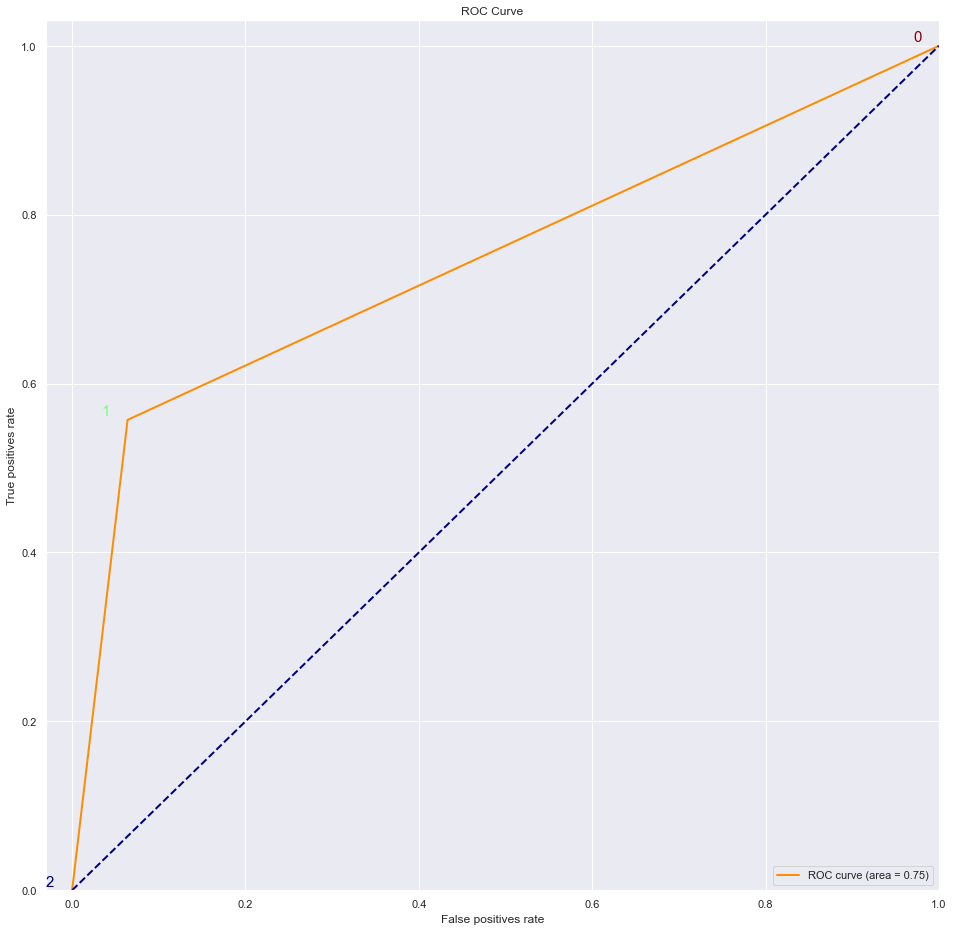

In [63]:
model = SVC(kernel='linear',C=0.1).fit(X_train, y_train)
plot_roc(y_test, model.predict(X_test), positive_label=1, thresholds_every=1, title="ROC Curve")

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [ ]:
# your code here